# Задача 7. Нейронные сети

## Задача

- [x] Найти данные в виде изображений для задачи классификации.
- [x] Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- [x] Использовать CrossEntropyLoss и L2-регуляризацию.
- [x] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [x] * (**+2 балла**) Добавить Batch normalization.
- [x] * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [x] * (**+1 балл**) Также реализовать оптимизатор Adam.

## Датасет

[Butterfly Image Classification](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) — содержит более 10 000 изображений 75 различных видов бабочек.

Каждое изображение имеет размер 224x224 пикселя. Класс каждого изображения хранится в файле Training_set.csv.

In [2]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tools import (
    NeuralClassifier,
    BatchNormClassifier,
    MomentumBatchNormClassifier,
    AdamBatchNormClassifier,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.core.magic import register_cell_magic


@register_cell_magic
def skip(line, cell):
    return

/Users/nikitalukonenko/Studying/third_course/ml-course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
folder = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")
training_set_path = os.path.join(folder, "Training_set.csv")

df = pd.read_csv(training_set_path)

df.head(5)

100%|██████████| 226M/226M [00:21<00:00, 11.1MB/s] 

Extracting files...


,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


Выберем несколько самых распространенных картинок в датасете для обучения нейронной сети.

In [4]:
class_counts = df["label"].value_counts().sort_values(ascending=False)

most_popular_classes = list(class_counts[:10].index)

df = df[df["label"].isin(most_popular_classes)]

print("Current size is:", df.size)
df.head(5)

Current size is: 2032


,filename,label
2,Image_3.jpg,BROWN SIPROETA
8,Image_9.jpg,BROWN SIPROETA
29,Image_30.jpg,ATALA
44,Image_45.jpg,RED CRACKER
52,Image_53.jpg,SCARCE SWALLOW


In [5]:
train_img_folder = os.path.join(folder, "train")


def load_image(filename):
    img_path = os.path.join(train_img_folder, filename)
    img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))) / 255.0
    return img.ravel()


df["image"] = df["filename"].apply(load_image)

df.head(3)

,filename,label,image
2,Image_3.jpg,BROWN SIPROETA,"[0.9254902, 0.9098039, 0.8980392, 0.9254902, 0..."
8,Image_9.jpg,BROWN SIPROETA,"[0.25882354, 0.43137255, 0.12156863, 0.2509804..."
29,Image_30.jpg,ATALA,"[0.7254902, 0.5803922, 0.3647059, 0.8039216, 0..."


## Запуск алгоритма

Выберем случайные параметры для первого тестового, чтобы посмотреть, какой результат получается.

In [6]:
class DefaultParams:
    input_num = 224 * 224 * 3
    classes_num = len(most_popular_classes)
    hidden_neurons_num = 512
    learning_rate = 0.0001
    epochs = 10


print(
    f"Create classifier with such params:\
    \n- Input neurons: {DefaultParams.input_num}\
    \n- Classes: {DefaultParams.classes_num}\
    \n- Hidden neurons: {DefaultParams.hidden_neurons_num}"
)

classifier = NeuralClassifier(
    DefaultParams.input_num, DefaultParams.classes_num, DefaultParams.hidden_neurons_num
)

Create classifier with such params:    
- Input neurons: 150528    
- Classes: 10    
- Hidden neurons: 512


Нужно поделить датасет на тренировочный и тестовый, а затем нормализовать тренировочный датасет

In [7]:
X = np.stack(df["image"].to_numpy())
labels = df["label"].to_numpy()

label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
y = np.array([label_mapping[label] for label in labels])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Теперь запустим сам алгоритм:

In [11]:
loss_values = classifier.train(
    X_train,
    y_train,
    alpha=DefaultParams.learning_rate,
    num_epochs=DefaultParams.epochs,
)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Default algorithm accuracy:  0.3382352941176471


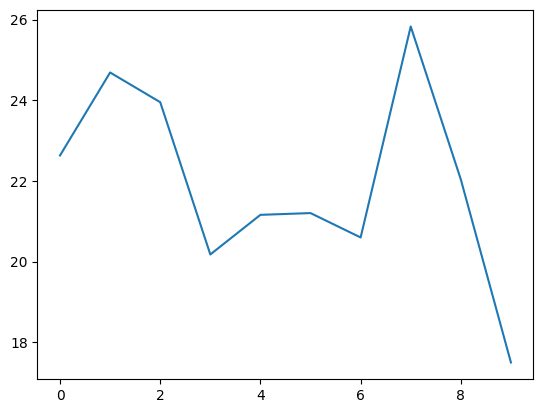

In [12]:
print("Default algorithm accuracy: ", accuracy)
plt.plot(loss_values)

Исходя из значения *accuracy*, можно сделать вывод, что модель обучилась и смогла выдать результат лучше, чем при простом угадывании (0.1). Теперь необходимо подобрать оптимальные параметры обучения и сравнить результат.

## Подбор параметров

Проведём подбор гиперпараметров:

In [18]:
def param_fit(
    hidden_neurons_num=512,
    batch_size=100,
    learning_rate=0.0001,
    reg=0.00001,
):
    classifier = NeuralClassifier(
        DefaultParams.input_num, DefaultParams.classes_num, hidden_neurons_num
    )

    loss_values = classifier.train(
        X_train, y_train, batch_size, learning_rate, reg=reg, num_epochs=20
    )

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, loss_values


def tune(param_name, param_values):
    accuracies = []

    for value in param_values:
        accuracy, _ = param_fit(**{param_name: value})
        accuracies.append(accuracy)

    return accuracies

In [19]:
param_grid = {
    "hidden_neurons_num": [512, 256, 128, 64],
    "batch_size": [100, 200, 300, 400, 500, 1000],
    "reg": [1.0, 0.5, 0.1, 0.15, 0.01, 0.001, 0.0001, 0.00001],
    "learning_rate": [1.0, 0.5, 0.1, 0.15, 0.01, 0.001, 0.0001, 0.00001],
}
accuracy_grid = {}

for param, values in param_grid.items():
    accuracy_grid[param] = tune(param, values)

    best_value_index = np.array(accuracy_grid[param]).argmax()
    print(f"Param: {param}, Best value: {param_grid[param][best_value_index]}")

Param: hidden_neurons_num, Best value: 64
Param: batch_size, Best value: 100
Param: reg, Best value: 1.0


/Users/nikitalukonenko/Studying/third_course/ml-course/solutions/tools.py:18: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(target_probs))
/Users/nikitalukonenko/Studying/third_course/ml-course/solutions/tools.py:18: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(target_probs))
/Users/nikitalukonenko/Studying/third_course/ml-course/solutions/tools.py:18: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(target_probs))


Param: learning_rate, Best value: 0.0001


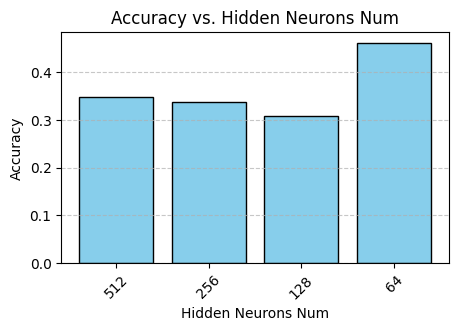

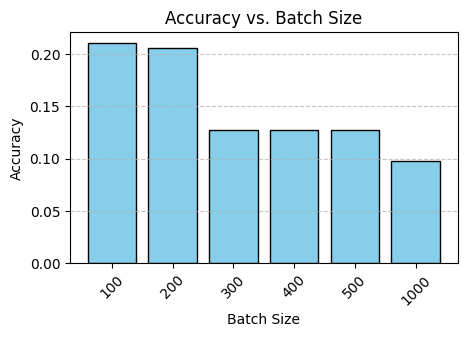

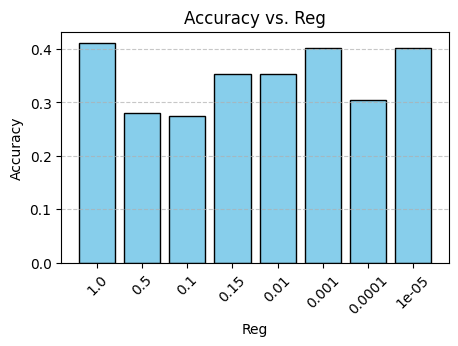

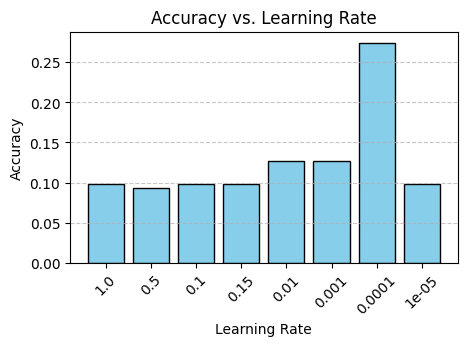

In [20]:
for param, accuracies in accuracy_grid.items():
    param_values = param_grid[param]

    plt.figure(figsize=(5, 3))
    plt.bar(
        range(len(param_values)),
        accuracies,
        tick_label=param_values,
        color="skyblue",
        edgecolor="black",
    )

    plt.xlabel(param.replace("_", " ").title())
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs. {param.replace('_', ' ').title()}")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()

Сохраню результаты для дальнейшего использования:

In [21]:
class BestParams:
    hidden_neurons_num = 512
    batch_size = 100
    learning_rate = 0.0001
    reg = 0.1
    epochs = 50

## Batch normalization

Применим *batch normalization* и сравним полученный результат с обычным классификатором, использовавшимся ранее. Для наибольшей эффективности, в качестве параметров классификаторов будем использовать полученные выше.

In [23]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    loss_values = model.train(
        X_train,
        y_train,
        batch_size=BestParams.batch_size,
        alpha=BestParams.learning_rate,
        reg=BestParams.reg,
        num_epochs=BestParams.epochs,
    )
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred), loss_values

In [24]:
batchnorm_classifier = BatchNormClassifier(
    DefaultParams.input_num, DefaultParams.classes_num, BestParams.hidden_neurons_num
)
simple_classifier = NeuralClassifier(
    DefaultParams.input_num, DefaultParams.classes_num, BestParams.hidden_neurons_num
)

batchnorm_accuracy, batchnorm_loss_values = train_and_evaluate(
    batchnorm_classifier, X_train, y_train, X_test, y_test
)
simple_accuracy, simple_loss_values = train_and_evaluate(
    simple_classifier, X_train, y_train, X_test, y_test
)

Accuracy with batch normalization: 0.3235
Simple classifier accuracy: 0.5539
Difference: 71.21%


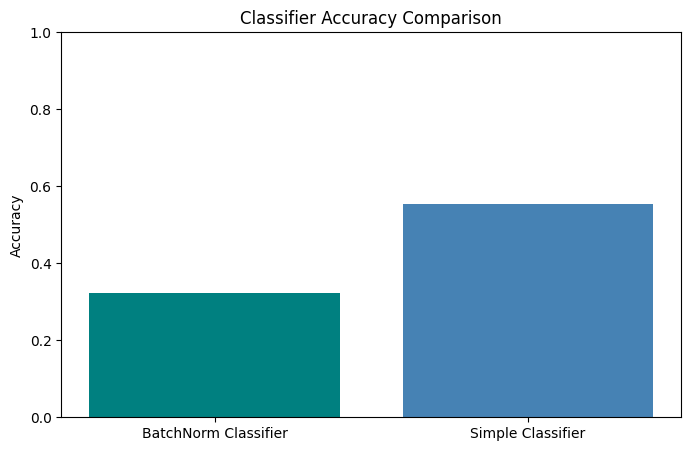

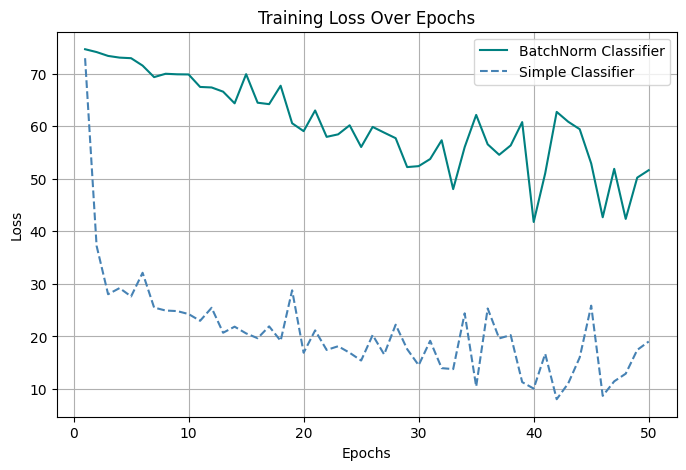

In [25]:
# Print accuracy
print(f"Accuracy with batch normalization: {batchnorm_accuracy:.4f}")
print(f"Simple classifier accuracy: {simple_accuracy:.4f}")

accuracy_diff = abs(batchnorm_accuracy - simple_accuracy)
relative_diff = (
    (accuracy_diff / min(batchnorm_accuracy, simple_accuracy)) * 100
    if min(batchnorm_accuracy, simple_accuracy) > 0
    else 0
)

print(f"Difference: {relative_diff:.2f}%")

# Accuracy Bar Plot
labels = ["BatchNorm Classifier", "Simple Classifier"]
accuracies = [batchnorm_accuracy, simple_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=["teal", "steelblue"])
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)
plt.show()

# Loss Plot
epochs = np.arange(1, len(batchnorm_loss_values) + 1)

plt.figure(figsize=(8, 5))
plt.plot(
    epochs,
    batchnorm_loss_values,
    label="BatchNorm Classifier",
    color="teal",
    linestyle="-",
)
plt.plot(
    epochs,
    simple_loss_values,
    label="Simple Classifier",
    color="steelblue",
    linestyle="--",
)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

В результате показатель accuracy стал получше.

## Оптимизаторы

### Momentum и Adam
Сравним результаты с оптимизаторами:

In [26]:
batchnorm_momentum_classifier = MomentumBatchNormClassifier(
    DefaultParams.input_num, DefaultParams.classes_num, BestParams.hidden_neurons_num
)
batchnorm_adam_classifier = AdamBatchNormClassifier(
    DefaultParams.input_num, DefaultParams.classes_num, BestParams.hidden_neurons_num
)

batchnorm_momentum_accuracy, batchnorm_momentum_loss_values = train_and_evaluate(
    batchnorm_momentum_classifier, X_train, y_train, X_test, y_test
)
batchnorm_adam_accuracy, batchnorm_adam_loss_values = train_and_evaluate(
    batchnorm_adam_classifier, X_train, y_train, X_test, y_test
)

Accuracy with Momentum optimization: 0.6275
Accuracy with Adam optimization: 0.2255
Difference: 178.26%


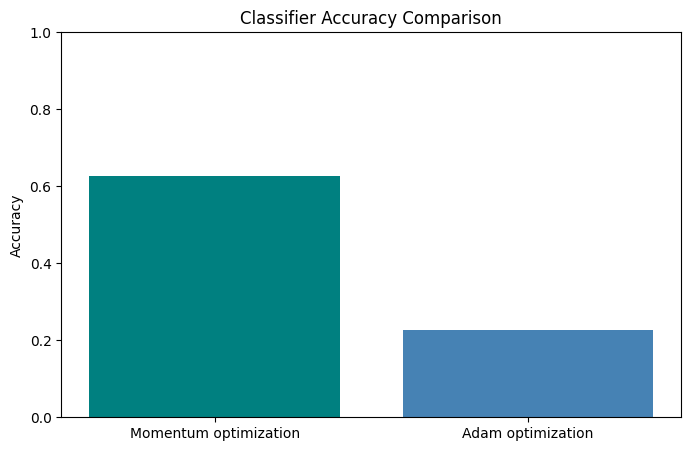

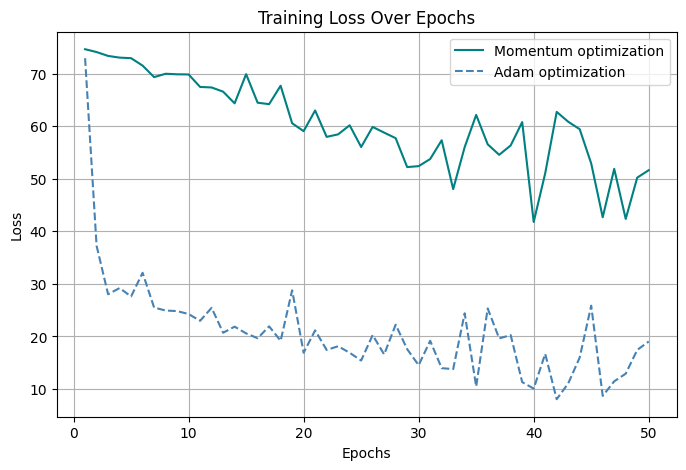

In [27]:
# Print accuracy
print(f"Accuracy with Momentum optimization: {batchnorm_momentum_accuracy:.4f}")
print(f"Accuracy with Adam optimization: {batchnorm_adam_accuracy:.4f}")

accuracy_diff = abs(batchnorm_momentum_accuracy - batchnorm_adam_accuracy)
relative_diff = (
    (accuracy_diff / min(batchnorm_momentum_accuracy, batchnorm_adam_accuracy)) * 100
    if min(batchnorm_momentum_accuracy, batchnorm_adam_accuracy) > 0
    else 0
)

print(f"Difference: {relative_diff:.2f}%")

# Accuracy Bar Plot
labels = ["Momentum optimization", "Adam optimization"]
accuracies = [batchnorm_momentum_accuracy, batchnorm_adam_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=["teal", "steelblue"])
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)
plt.show()

# Loss Plot
epochs = np.arange(1, len(batchnorm_loss_values) + 1)

plt.figure(figsize=(8, 5))
plt.plot(
    epochs,
    batchnorm_loss_values,
    label="Momentum optimization",
    color="teal",
    linestyle="-",
)
plt.plot(
    epochs,
    simple_loss_values,
    label="Adam optimization",
    color="steelblue",
    linestyle="--",
)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Из сравнения видно, что, Adam значительно улучшил показатели по сравнению с Momentum.

## Заключение
В ходе работы была реализована нейросеть для классификации изображений:
- В качестве датасета была выбрана коллекция изображений с более чем 10 000 экземплярами бабочек. 
- Из датасета были выбраны наиболее популярные данные. Тренировочный датасет был нормализован для наиболее высоких результатов обучения модели.
- Реализованы два линейных слоя и один нелинейный (с функцией *Relu*).
- Использованы *CrossEntropyLoss* и *L2-регуляризация*.
- Проведено обучение модели, подбор гиперпараметров и оценка качества на тестовой выборке.
- Добавлена *Batch normalization*, реализован и применён оптимизатор Momentum.
- Реализован оптимизатор *Adam*.
- Выполнено сравнение результатов между всеми получившимися классификаторами.

Из всех реализаций, лучшим оказался классификатор, использующий оптимизатор *Adam* и *Batch Normalization*.